In [1]:
import extFunc as ext
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import numpy as np
from importlib import import_module
import pandas as pd 
import cobra
import optlang
import copy 
import random

In [2]:
#Load Models if not already in RAM

#nameList = ['iJN1462_GLC_UR10_9.xml' , 'iJN1462_GLC_UR6_3.xml', 'iJN1462_GLN_UR5_1.xml', 'iJN1462_GLC_UR7_3.xml' , 'iJN1462_OCT_UR3_4.xml']
#nameList = ['iJN1462_GLC_UR6_3.xml' , 'iJN1462_OCT_UR3_4.xml']
nameList = ['iJN1462_OCT_UR3_4.xml']

if 'modelDict' not in locals():
    modelDict = ext.ImportFunction(nameList)



if 'glc_oct_comp'  not in locals():
    glc_oct_comp = ext.ModelComparison(modelDict=modelDict)


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
#Base case as in Nogales Paper
model           = modelDict['iJN1462_OCT_UR3_4']
model_bounded   = copy.deepcopy(model)

fv                  = cobra.flux_analysis.flux_variability_analysis(model)
fv["cumulative"]    = abs(fv.maximum) + abs(fv.minimum)


173


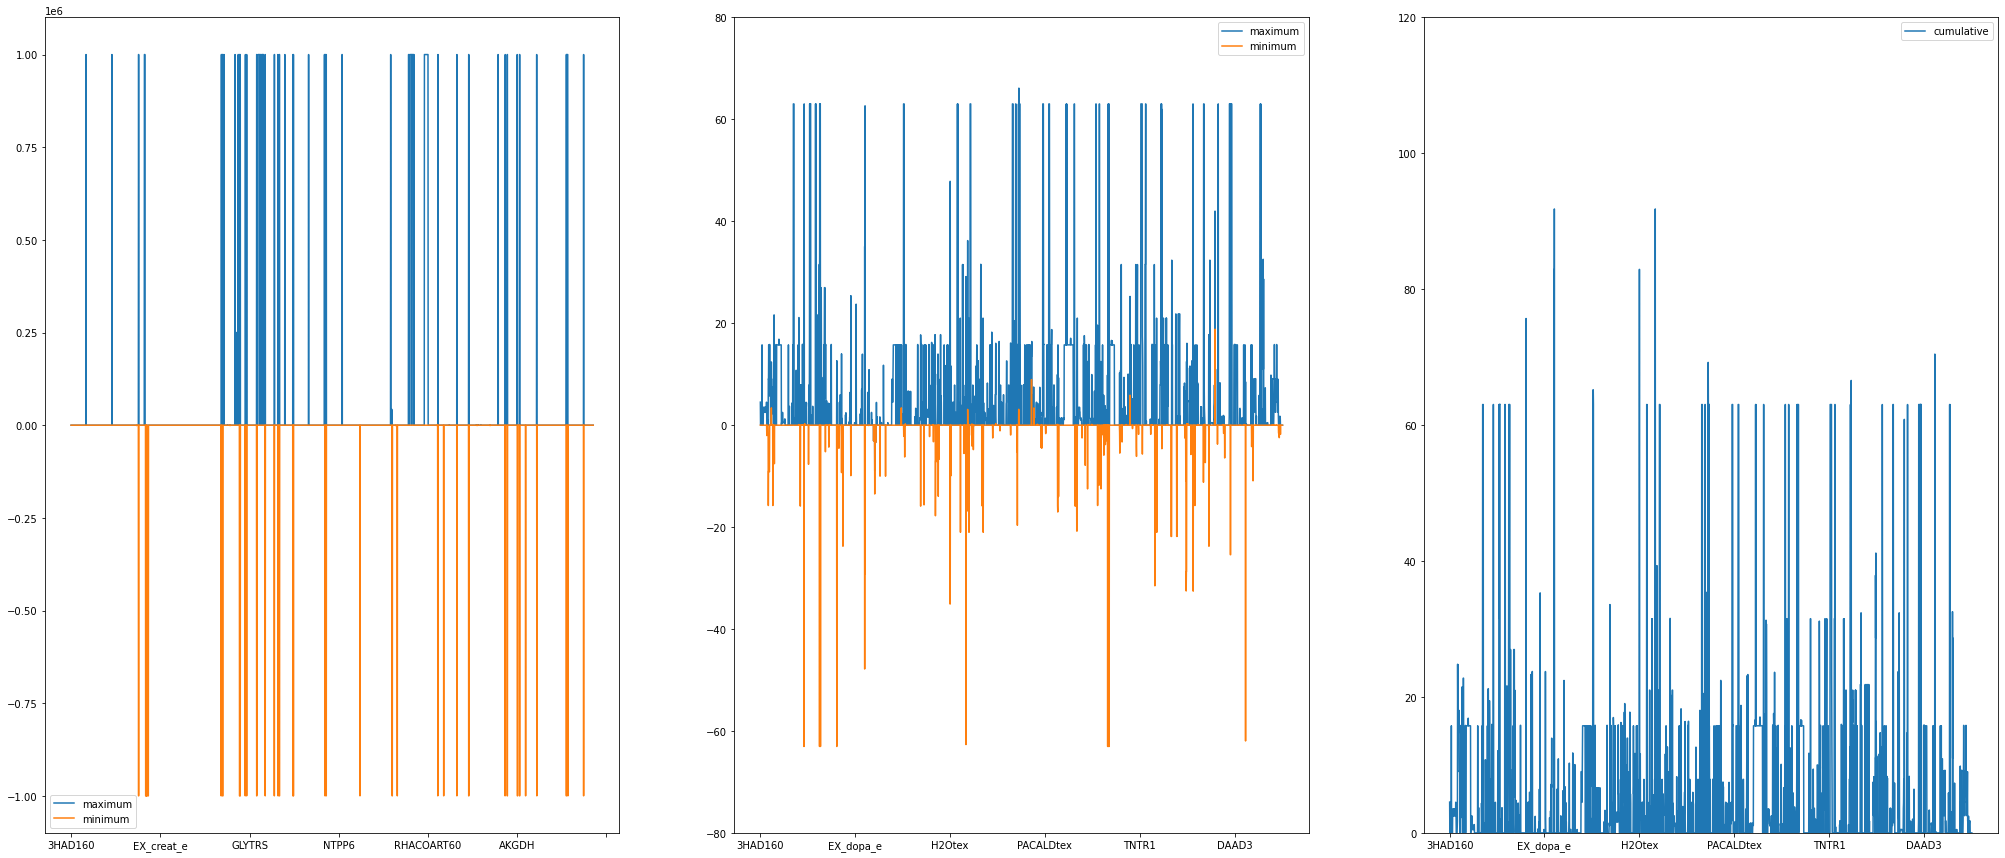

In [4]:
filterV = 200
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(35,15))
fv.plot( y=["maximum", "minimum"],ax=axes[0])
fv[(abs(fv.maximum)<filterV) & (abs(fv.minimum)<filterV)].plot( y=["maximum", "minimum"],ax=axes[1],ylim=[-80,80])
fv[(abs(fv.maximum)<filterV) & (abs(fv.minimum)<filterV)].plot( y=["cumulative"],ax=axes[2],ylim=[0,120])

## save list of filtered for later

list_of_filtered = fv[(abs(fv.maximum)>filterV) | (abs(fv.minimum)>filterV)]
print(len(list_of_filtered))


Assumption through high default boundaries overal variability artificially strethed ?
Test, Measure the overall cumulative variability for the bounded and unbound optimized cases.
If a difference is visible after removig the artificially stretched reactions, this would mean that theire was an influence

In [5]:

bounded_model = copy.deepcopy(model)

for reaction in bounded_model.reactions:
    if abs(reaction.lower_bound)>50:
        reaction.lower_bound= -30
    if abs(reaction.upper_bound)>50:
        reaction.upper_bound=30
        
fv_new_model  = cobra.flux_analysis.flux_variability_analysis(bounded_model)
fv_new_model["cumulative"]    = abs(fv_new_model.maximum) + abs(fv_new_model.minimum)

<AxesSubplot:>

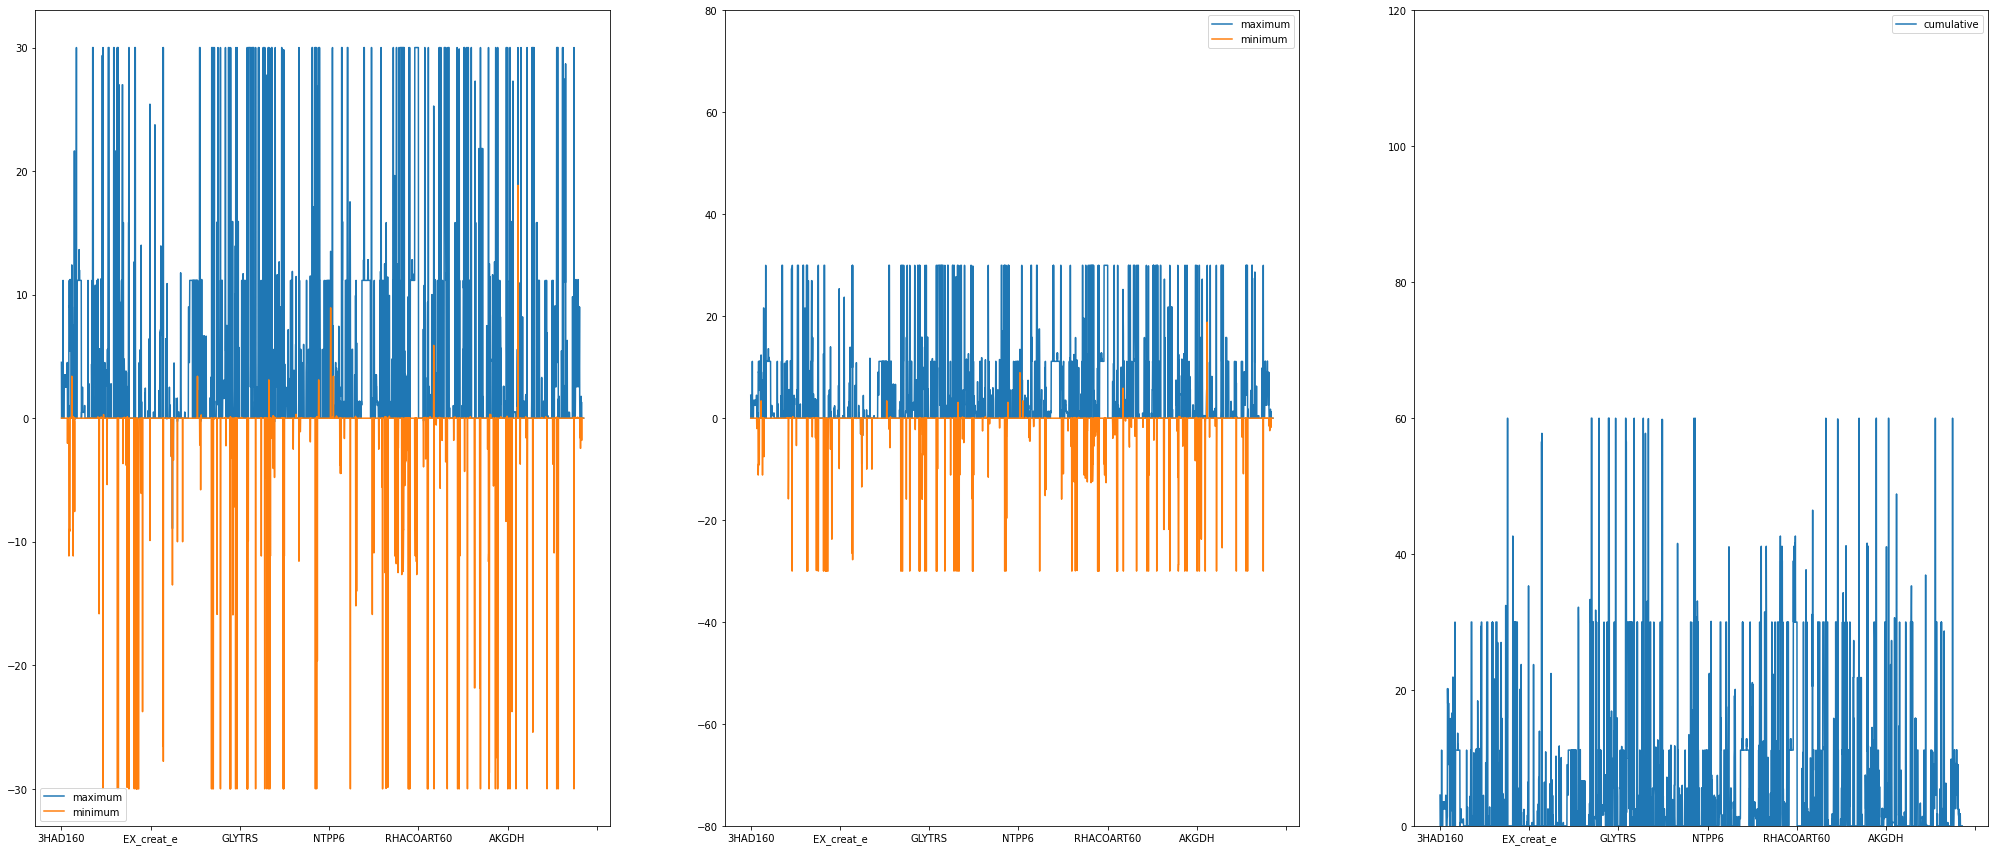

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fv_new_model.plot( y=["maximum", "minimum"],ax=axes[0],figsize=(35,15))
fv_new_model[(abs(fv_new_model.maximum)<200)&(abs(fv_new_model.minimum)<200)].plot( y=["maximum", "minimum"],ax=axes[1],ylim=[-80,80])
fv_new_model.plot( y=["cumulative"],ax=axes[2],ylim=[0,120])


Assumption through high default boundaries overal variability artificially strethed ?
Test, Measure the overall cumulative variability for the bounded and unbound optimized cases.
If a difference is visible after removig the artificially stretched reactions, this would mean that theire was an influence

<AxesSubplot:>

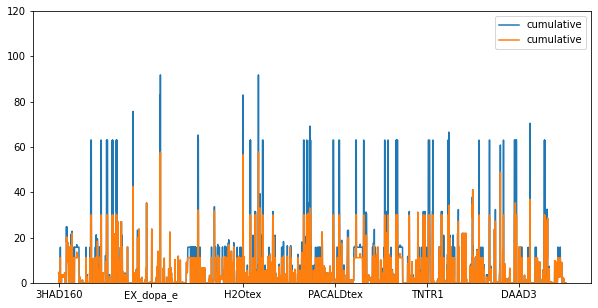

In [7]:
filter = list_of_filtered.index

ax1 =   fv[~fv.index.isin(filter)].plot( y=["cumulative"],ylim=[0,120]                )
fv_new_model[~fv_new_model.index.isin(filter)].plot( y=["cumulative"],ax=ax1)

Number of reactions,for which the result of the FVA changed through reducing the biggest boundaries 1219
seems as if a signifant account might be numerical, because of small differences 


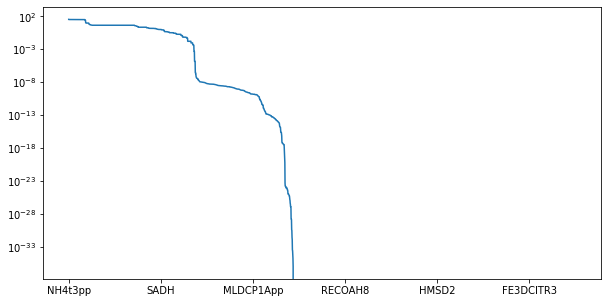

In [8]:
diff=fv[~fv.index.isin(filter)]["cumulative"] - fv_new_model[~fv_new_model.index.isin(filter)]["cumulative"]
diff.sort_values(ascending=False).plot(logy=True)
nonzero_diff = diff[diff > 0]

print("Number of reactions,for which the result of the FVA changed through reducing the biggest boundaries " + str(len(nonzero_diff)))
print("seems as if a signifant account might be numerical, because of small differences ")

here maybe x and y axis with logscale, to make differences in 


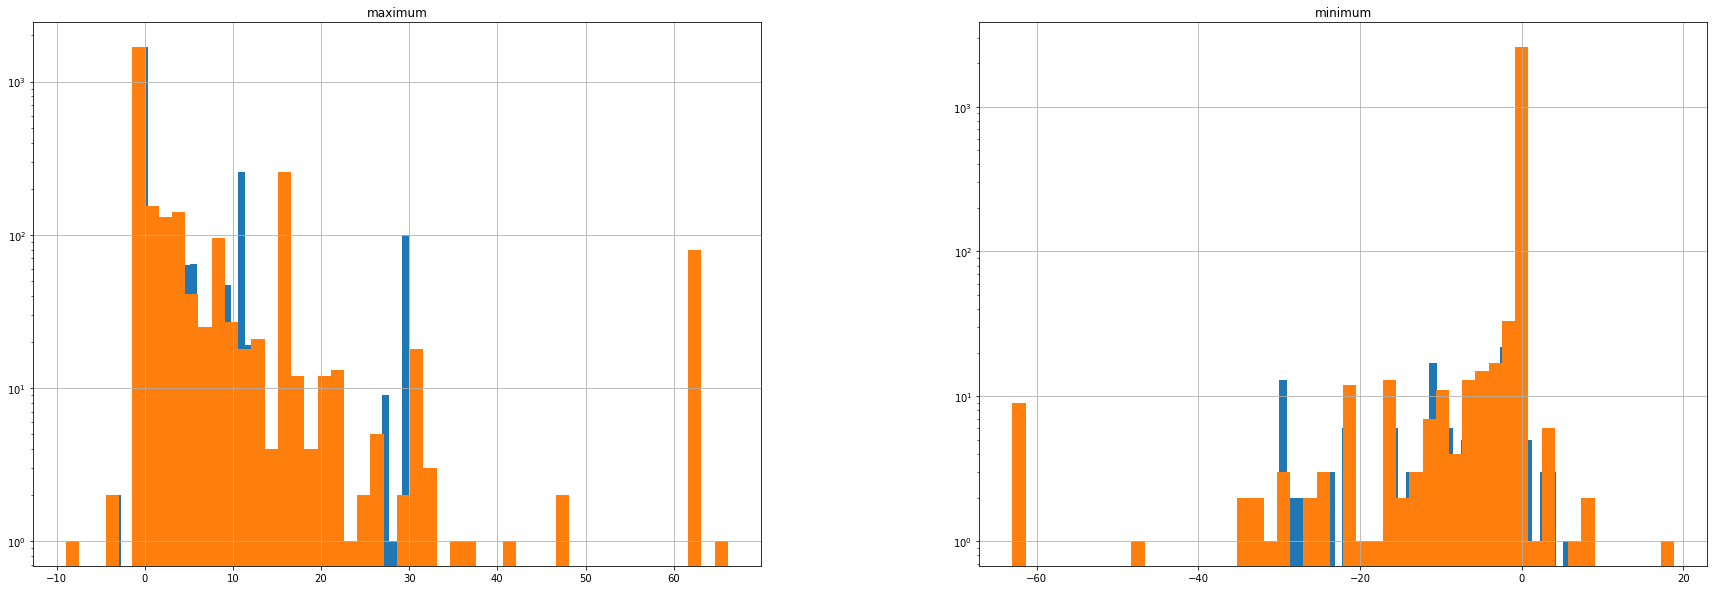

In [9]:
#bin_array = np.logspace(1e-4,1e+4,9)
axA = fv_new_model[~fv_new_model.index.isin(filter)].hist(column=["maximum", "minimum"] , log=True,bins=50,figsize=(30,10))
fv[~fv.index.isin(filter)].hist(column=["maximum", "minimum"] , log=True, bins=50, ax=axA)
print("here maybe x and y axis with logscale, to make differences in ")

In [10]:
modelDict = {
    "baseCaseOctanoat" : model ,
    "boundariesLimited to +/- 50" : bounded_model 
    }
comparisonObjectBoundaedModels = ext.ModelComparison(modelDict=modelDict)
comparisonObjectBoundaedModels.multiModellSummary(fvaDIr=.99,sortKrit='C-Flux')

Uptake                          \
                               metabolite      reaction      flux   
baseCaseOctanoat            0     octa[e]     EX_octa_e  3.400000   
                            1  pqqA_kt[c]  SK_pqqA_kt_c  0.000065   
                            2      nh4[e]      EX_nh4_e  3.100000   
                            3     PHAg[c]     SK_PHAg_c  1.117172   
                            4      zn2[e]      EX_zn2_e  0.000820   
boundariesLimited to +/- 50 0     octa[e]     EX_octa_e  3.400000   
                            1  pqqA_kt[c]  SK_pqqA_kt_c  0.000065   
                            2      nh4[e]      EX_nh4_e  3.100000   
                            3     PHAg[c]     SK_PHAg_c  1.117172   
                            4      zn2[e]      EX_zn2_e  0.000820   

                                                                               \
                                                                        range   
baseCaseOctanoat            0                                      (3.4, 3.4)   
                            1  (6.494637531958849e-05, 6.494637532777384e-05)   
                            2                        (3.100000000000056, 3.1)   
                            3        (-61.96157606753143, 4.6243234021286765)   
                            4  (0.0008204212523555191, 0.0008204212556909927)   
boundariesLimited to +/- 50 0                                      (3.4, 3.4)   
                            1  (6.494637531958783e-05, 6.494637531958711e-05)   
                            2                        (3.100000000000147, 3.1)   
                            3                      (-30.0, 4.314059263637936)   
                            4  (0.0008204212523555108, 0.0008204212523557446)   

                                                     Secretion                 \
                              C-Number     C-Flux   metabolite       reaction   
baseCaseOctanoat            0        8  99.996657   C80aPHA[c]   DM_C80aPHA_c   
                            1       14   0.003343       co2[e]       EX_co2_e   
                            2        0   0.000000  R_3hocta[e]  EX_R_3hocta_e   
                            3        0   0.000000        ac[e]        EX_ac_e   
                            4        0   0.000000      amob[c]      DM_amob_c   
boundariesLimited to +/- 50 0        8  99.996657   C80aPHA[c]   DM_C80aPHA_c   
                            1       14   0.003343       co2[e]       EX_co2_e   
                            2        0   0.000000  R_3hocta[e]  EX_R_3hocta_e   
                            3        0   0.000000        ac[e]        EX_ac_e   
                            4        0   0.000000     5drib[c]     DM_5drib_c   

                                         \
                                   flux   
baseCaseOctanoat            0 -1.117172   
                            1 -3.171260   
                            2 -0.377543   
                            3 -0.171264   
                            4 -0.000065   
boundariesLimited to +/- 50 0 -1.117172   
                            1 -3.171260   
                            2 -0.377543   
                            3 -0.171264   
                            4 -0.000195   

                                                                                  \
                                                                           range   
baseCaseOctanoat            0             (-8.504986018141478, 61.9615762992542)   
                            1            (-25.41974670271636, 9.900955463705717)   
                            2                         (-63.042034168330794, 0.0)   
                            3                         (-32.557562517339214, 0.0)   
                            4   (-6.494646467957756e-05, -6.494637531958848e-05)   
boundariesLimited to +/- 50 0                         (-6.921652210348052, 30.0)   
                            1           (-25.419746702715777, 9.9009554

In [11]:
fl = bounded_model.optimize().fluxes
fl[abs(fl)>5]

CYTBO3_4pp    25.926893
EX_h2o_e      14.506390
EX_o2_e      -13.500000
H2Otex       -14.506390
H2Otpp       -13.616211
MDH2           7.791538
O2tex         13.500000
O2tpp         13.049216
PPK           -5.858994
SUCD4          9.458851
ATPS4rpp      27.390922
Name: fluxes, dtype: float64

/var/folders/wg/bd6gkggs51b4d1lbpsbxnw0r0000gn/T/ipykernel_75632/2689618705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fv_main_carbonpath["ind_nr"] = ind_nr


<AxesSubplot:>

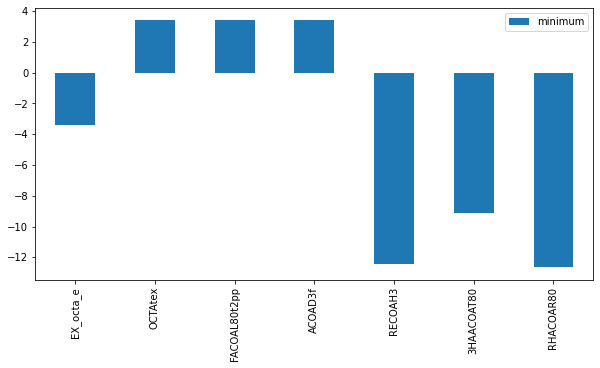

In [20]:
#bounded_model.reactions.get_by_id("DM_C*"]
octanoate_path_reaction_ids =   [ "EX_octa_e","OCTAtex", "FACOAL80t2pp", "ACOAD3f", "RECOAH3", "3HAACOAT80", "RHACOAR80"]
ind_nr                      =   [6, 4 , 1, 3, 2,5,7]
fv_main_carbonpath = fv[fv.index.isin(octanoate_path_reaction_ids)]
fv_main_carbonpath["ind_nr"] = ind_nr
fv_main_carbonpath[fv_main_carbonpath<1000].sort_values("ind_nr").plot.bar(y=['minimum',])
